# Get the Data

In [25]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

#### Create a Test Set

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

# Explore the Data

In [27]:
housing = strat_train_set.copy()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   total_bedrooms      16344 non-null  float64 
 5   population          16512 non-null  float64 
 6   households          16512 non-null  float64 
 7   median_income       16512 non-null  float64 
 8   median_house_value  16512 non-null  float64 
 9   ocean_proximity     16512 non-null  object  
 10  income_cat          16512 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.4+ MB


<Axes: xlabel='longitude', ylabel='latitude'>

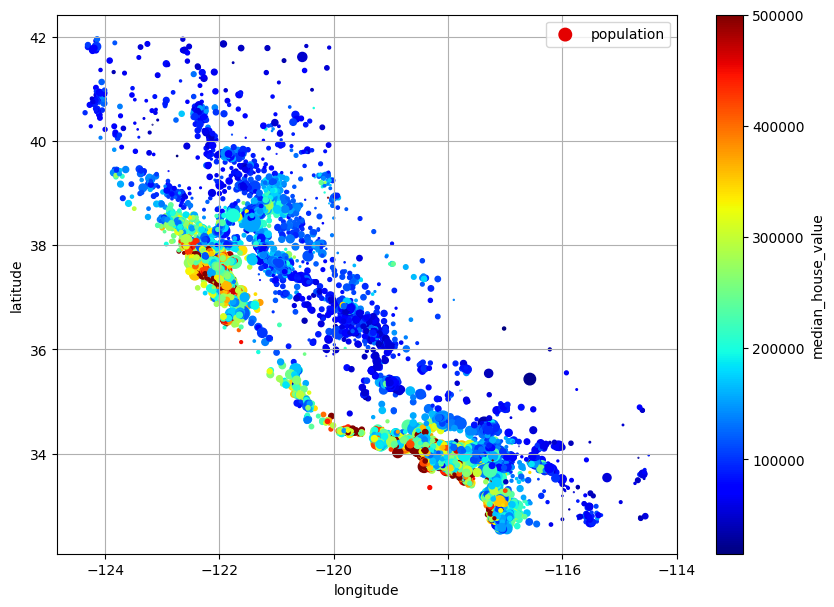

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

In [29]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

In [30]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Prepare the Data

In [31]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [32]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out


def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore"))
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)

# Shortlist Promising Models

#### Linear Regression Model

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)
housing_labels.iloc[:5].values

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse


c:\Users\kentl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(68300.8872739978)

#### Decision Tree Regressor

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

housing_predictions = tree_reg.predict(housing)
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     67216.025768
std       1922.191058
min      64687.848594
25%      66117.451107
50%      67234.133602
75%      67626.227487
max      71011.076018
dtype: float64

#### Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [36]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47133.159474
std       1021.454606
min      45495.652291
25%      46678.748270
50%      47239.749141
75%      47477.709571
max      49311.141107
dtype: float64

#### Gradient Boosting Regressor

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

grad_reg = make_pipeline(preprocessing, 
                         GradientBoostingRegressor(random_state=42))
grad_reg.fit(housing, housing_labels)

housing_predictions = grad_reg.predict(housing)
grad_rmses = -cross_val_score(grad_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)


In [38]:
pd.Series(grad_rmses).describe()

count       10.000000
mean     51325.649044
std        845.418424
min      49954.987514
25%      51096.046013
50%      51293.880546
75%      51432.503706
max      53366.030398
dtype: float64

# Fine-Tune the System

#### Grid Search

#### Randomized Search

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016AE7EE37A0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000016AE7EE1AC0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [40]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.05, 0.04, 0.05, 0.01, 0.01, 0.01, 0.01, 0.15, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.01, 0.01,
       0.01, 0.01, 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01,
       0.02, 0.01, 0.  , 0.02, 0.01, 0.03, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.06,
       0.  , 0.  , 0.  , 0.01, 0.14])

In [41]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.14838866459853628), 'log__median_income'),
 (np.float64(0.13781451371267514), 'remainder__income_cat'),
 (np.float64(0.060181393505387246), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.0517085676481056), 'people_per_house__ratio'),
 (np.float64(0.04766231777749664), 'bedrooms__ratio'),
 (np.float64(0.03969419150738284), 'rooms_per_house__ratio'),
 (np.float64(0.03377719122046225), 'geo__Cluster 30 similarity'),
 (np.float64(0.02218884335756343), 'geo__Cluster 9 similarity'),
 (np.float64(0.020789647605098844), 'geo__Cluster 36 similarity'),
 (np.float64(0.01984066495132398), 'geo__Cluster 3 similarity'),
 (np.float64(0.01792959770850853), 'geo__Cluster 18 similarity'),
 (np.float64(0.01628591288739606), 'geo__Cluster 25 similarity'),
 (np.float64(0.01609202387292049), 'geo__Cluster 32 similarity'),
 (np.float64(0.015219937398710623), 'geo__Cluster 28 similarity'),
 (np.float64(0.014371663053906608), 'geo__Cluster 1 similarity'),
 (np.float64(0.013908104710464499), 'rem

In [42]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

42123.85189565645


c:\Users\kentl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39967.17738678, 44175.36110535])